# M&M model VEM updates

In [1]:
dat = readRDS('/home/gaow/Documents/GTExV8/Thyroid.Lung.FMO2.filled.rds')
attach(dat)

In [2]:
%get X Y --from R
Y = Y.as_matrix()

Loading required package: feather


In [3]:
from libgaow.regression_data import MASH
from libgaow.model_mash import PriorMASH
import numpy as np

In [4]:
class MNMASH:
    def __init__(self, X=None, Y=None, Z=None, B=None, S=None, V=None):
        self.mash = MASH(X=X,Y=Y,Z=Z,B=B,S=S,V=np.cov(Y, rowvar=False) if V is None else V)
        self.Y = Y
        # variational parameter for the one-nonzero effect model for each l and j
        self.alpha0 = None
        # posterior mean on \beta_lj
        self.mu0 = None
        self.Xr0 = np.zeros((self.Y.shape[0], self.Y.shape[1]))
        self.elbo = []
        self.post_mean_mat = None
    
    def set_prior(self, U, grid, pi):
        self.mash.set_prior(U, grid, pi)

    def fit(self, niter=100, L=5, calc_elbo=False):
        self.alpha0 = np.zeros((L, self.mash.X.shape[1]))
        self.mu0 = np.zeros((L, self.mash.X.shape[1], self.Y.shape[1]))
        for i in range(niter):
            self._calc_update()
            if calc_elbo:
                self._calc_elbo()
        self._calc_posterior()

    def _calc_update(self):
        for l in range(self.alpha0.shape[0]):
            self.Xr0 -= self.mash.X @ (np.vstack(self.alpha0[l,:]) * self.mu0[l,:,:])
            self.alpha0[l,:], self.mu0[l,:,:] = self._calc_single_snp(self.Y - self.Xr0)
            self.Xr0 += self.mash.X @ (np.vstack(self.alpha0[l,:]) * self.mu0[l,:,:])

    def _calc_single_snp(self, R):
        self.mash.reset({'Y': R})
        self.mash.get_summary_stats()
        self.mash.fit()
        bf = np.exp(self.mash.l10bf)
        return bf/np.sum(bf), self.mash.post_mean_mat.T  

    def _calc_elbo(self):
        pass

    def _calc_posterior(self):
        almu = np.zeros((self.mu0.shape[0], self.mu0.shape[1], self.mu0.shape[2]))
        for l in range(self.alpha0.shape[0]):
            almu[l,:,:] = np.vstack(self.alpha0[l,:]) * self.mu0[l,:,:]
        self.post_mean_mat = np.sum(almu, axis = 0)

In [5]:
class ELBOMNM:
    def __init__(self, data):
        self.data = data

In [6]:
model = MNMASH(X=X,Y=Y)

In [7]:
model.set_prior({'identity': np.identity(2), 
                 'single_1': np.array([[1,0],[0,0]]), 
                 'single_2': np.array([[0,0], [0,1]]), 
                 'all_in': np.ones((2,2))}, 
                [0.5,1], 
                [0.9,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.02])

In [8]:
model.fit(niter = 100)

In [10]:
model.post_mean_mat

array([[ -1.04291072e-21,  -5.58051289e-22],
       [ -1.77377302e-15,  -1.76887967e-15],
       [ -1.15121535e-18,  -1.15039931e-18],
       ..., 
       [  6.76559354e-21,   2.61296975e-21],
       [ -1.08939477e-19,  -5.34275355e-20],
       [  8.73588121e-21,   3.50093772e-21]])

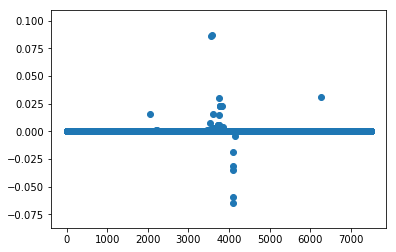

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.scatter([x+1 for x in range(len(model.post_mean_mat[:,0]))], model.post_mean_mat[:,0], cmap="viridis")
ax = plt.gca()
plt.show()

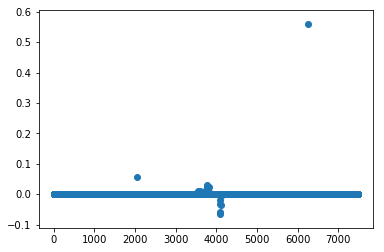

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.scatter([x+1 for x in range(len(model.post_mean_mat[:,1]))], model.post_mean_mat[:,1], cmap="viridis")
ax = plt.gca()
plt.show()